In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from bluerecording.writeH5 import getSegmentMidpts,sort_electrode_names, getArraySpacing
%matplotlib ipympl

ModuleNotFoundError: No module named 'mpi4py'

### Loads the values of the CSD coefficients

In [ ]:
fname = 'csd_paper/electrodes/derivative.h5'

f = h5py.File(fname)


### Loads the electrode positions from the H5 file containing the LFP coefficients

In [11]:
originalFile = h5py.File('csd_paper/electrodes/coeffs_highRes.h5')
electrodeNames = sort_electrode_names(originalFile['electrodes'].keys(),'S1nonbarrel_neurons')
allEpos = []
for e in electrodeNames:
    allEpos.append( originalFile['electrodes'][str(e)]['position'][:] )
allEpos = np.array(allEpos)
originalFile.close()
allEpos = allEpos[1:-1] # Removes the first and last electrodes, since taking the second derivative loses them

In [13]:
main_axis, arraySpacing = getArraySpacing(allEpos) # Gets array spacing and main axis of the electrode array

In [14]:
def distances_in_planar_coords(compartment_positions, electrodePos, main_axis):

    '''
    For a disk or plane perpendicular to main_axis, returns the axial and radial coordinates of each of the compartment positions
    '''

    from bluerecording.writeH5 import calculate_axial_vectors

    ### Projects compartment positions onto plane, containing the point electrodePos, normal to electrode array
    differenceVectors = compartment_positions.values - electrodePos[:,np.newaxis]

    axialDistances = np.matmul(differenceVectors.T,main_axis) # Size len(compartment_positions)x1

    return axialDistances

### Finds the node ids of the neurons in the central column

In [16]:
import bluepysnap as bp

In [17]:
c = bp.Simulation('csd_paper/electrodes/simulation_config.json')

In [18]:
hex0 = next(c.circuit.nodes.get('hex0',properties=['mtype']))

In [19]:
hex0Ids = np.array(hex0[1].loc['S1nonbarrel_neurons'].index)

In [20]:
np.save('hex0Ids.npy',hex0Ids)

### Reads the position files, selects neurons, and finds the CSD coefficient and distance from selected electrode for each segment

In [ ]:
electrodeIndices = [10,25,50,75,90] # Sampling of electrodes across the column
allDistances = []
allCsdCoeffs = []
np.random.seed(2643)


for electrodeIdx in electrodeIndices:
    csdCoeffs = []
    distances = []

    numFiles = 0
    numNeurons = 0

    for dirpath, dirnames, filenames in os.walk('csd_paper/electrodes/positions'):
            for filename in filenames:
                
                file_path = os.path.join(dirpath, filename)
                positions = pd.read_pickle(file_path) # Loads pickle file containing segment positions for 1000 neurons
                
                node_ids = np.unique(np.array(list(positions.columns))[:,0]) # Reads node ids contained in this position file

                node_ids = node_ids[np.isin(node_ids,hex0Ids)] # Selects the node ids which are in the central column

                newNodeIds = np.random.choice(node_ids,int(0.05*len(node_ids)),replace=False) # Selects a 5% random sample of these

                newPos = getSegmentMidpts(positions[newNodeIds],newNodeIds) # Identifies geometric centers of each segment
    
                for ids in newNodeIds:

                    ### Finds indices in the weights file of the neural segments in each node id
    
                    nodeIndex = np.where(f['S1nonbarrel_neurons']['node_ids']==ids)[0][0]
    
                    offset = f['S1nonbarrel_neurons']['offsets'][nodeIndex]
                    offset1 = f['S1nonbarrel_neurons']['offsets'][nodeIndex+1]

                    ######
                    
                    distances.append(distances_in_planar_coords(newPos[ids],allEpos[electrodeIdx],main_axis)) # Vertical distance between segment and electrode
                    
                    csdCoeffs.append(f['electrodes']['S1nonbarrel_neurons']['scaling_factors'][offset:offset1,electrodeIdx]) # Coefficients for the electrode


    allCsdCoeffs.append(csdCoeffs)
    allDistances.append(distances)
    
            

/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=False).apply(getNeuronSegmentMidpts)
/home/tharayil/BlueRecording/bluerecording/writeH5.py:442: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  newPos = positions.groupby(level=0,axis=1,group_keys=F

### Plots Figure 2 in the paper

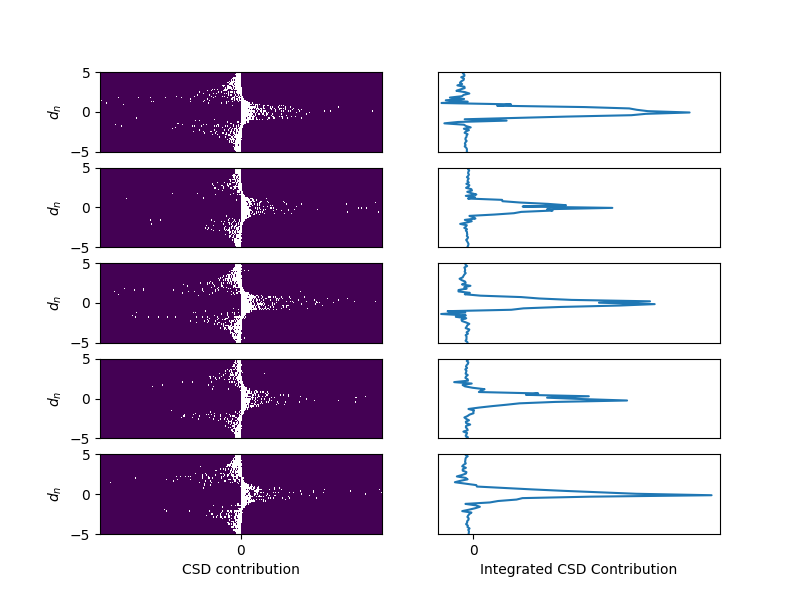

In [22]:

fig, axes = plt.subplots(5,2,figsize=(8,6))

for i in range(5):

    
    # Iterates through electrodes backwards, since electrodes are stored from the bottom to the top of the column
    distances = allDistances[4-i] 
    csdCoeffs = allCsdCoeffs[4-i]
    
    distances = np.array(distances)
    csdCoeffs = np.array(csdCoeffs)

    # Stacks distances and coefficients from each neuron, stored as separate lists, into a single contiguous numpy array
    newDistances = distances[0]
    for d in distances[1:]:
        newDistances = np.vstack((newDistances,d))
    
    newcoeffs = csdCoeffs[0][:,np.newaxis]
    for c in csdCoeffs[1:]:
        newcoeffs = np.vstack((newcoeffs,c[:,np.newaxis]))


    axes[i][0].hist2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000],cmin=0,cmax=0.5) # Plots histogram (effectively a scatter plot) of CSD coefficients and vertical distances
    
    if i == 4:
        axes[i][0].set_xlabel('CSD contribution')
        axes[i][0].set_xticks([0])
    else:
        axes[i][0].set_xticks([])
        
    axes[i][0].set_xlim([-5e-6,5e-6])

    axes[i][0].set_ylabel('$d_n$')
    axes[i][0].set_ylim([-5,5])


    hist, xbins, ybins = np.histogram2d(newcoeffs[:,0],newDistances[:,0]/20,bins=[10000,1000]) # Gets bin and density values for the histogram
    xvals = (xbins[1:]+xbins[:-1])/2
    yvals = (ybins[1:]+ybins[:-1])/2

    axes[i][1].plot(np.sum(hist*xvals[:,np.newaxis],axis=0),yvals) # Integrates histogram over each distance bin
    axes[i][1].set_ylim([-5,5])

    if i == 4:
        axes[i][1].set_xlabel('Integrated CSD Contribution')
        axes[i][1].set_xticks([0])
    else:
        axes[i][1].set_xticks([])
        
    axes[i][1].set_yticks([])
    axes[i][1].set_xlim([-5e-5,35e-5])

plt.savefig('figures/histograms.png')

In [ ]:
np.save('allCoeffs.npy',allCsdCoeffs)
np.save('allDistances.npy',allDistances)

In [20]:
allCsdCoeffs = np.load('allCoeffs.npy',allow_pickle=True)
allDistances = np.load('allDistances.npy',allow_pickle=True)